In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer


In [4]:
# Load the data
df = pd.read_csv("creditcard.csv")

# If dataset has more than 50,000 rows, sample; else use full data
if len(df) > 50000:
    df_sampled = df.sample(n=50000, random_state=42).reset_index(drop=True)
else:
    df_sampled = df.copy()
    print(f"Dataset has only {len(df)} rows; using full dataset.")


Dataset has only 23858 rows; using full dataset.


In [5]:
# Separate features and label
X = df_sampled.drop(['Class', 'Time'], axis=1)
y = df_sampled['Class']

In [6]:

# Impute missing values if any
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [7]:

# Apply DBSCAN
dbscan = DBSCAN(eps=2.2, min_samples=5)
cluster_labels = dbscan.fit_predict(X_pca)

# Create dataframe for visualization and analysis
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = cluster_labels
df_pca['Actual_Fraud'] = y.values


In [8]:

# Evaluation
core_mask = cluster_labels != -1
if len(set(cluster_labels[core_mask])) > 1:
    sil_score = silhouette_score(X_pca[core_mask], cluster_labels[core_mask])
    db_index = davies_bouldin_score(X_pca[core_mask], cluster_labels[core_mask])
else:
    sil_score = None
    db_index = None

print(f"Silhouette Score (excluding noise): {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Number of outliers detected (Cluster = -1): {(cluster_labels == -1).sum()}")


Silhouette Score (excluding noise): 0.8846751220953017
Davies-Bouldin Index: 0.22082663390289084
Number of outliers detected (Cluster = -1): 0


In [10]:

# Count the number of unique clusters excluding noise (-1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found (excluding noise): {n_clusters}")


Number of clusters found (excluding noise): 3


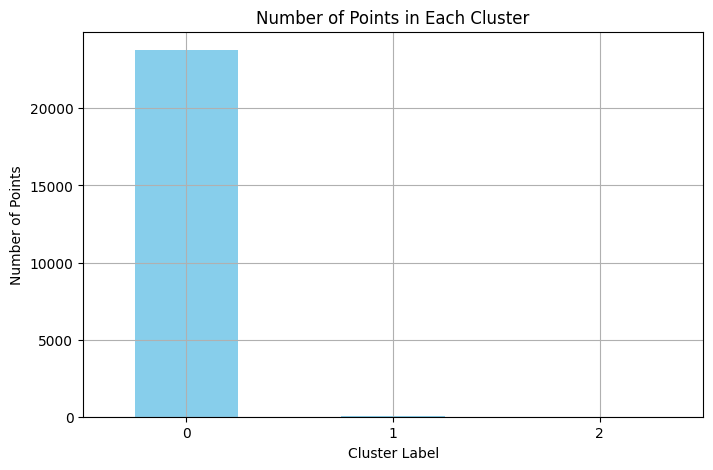

In [11]:

# Plot number of points per cluster
import matplotlib.pyplot as plt

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Points in Each Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


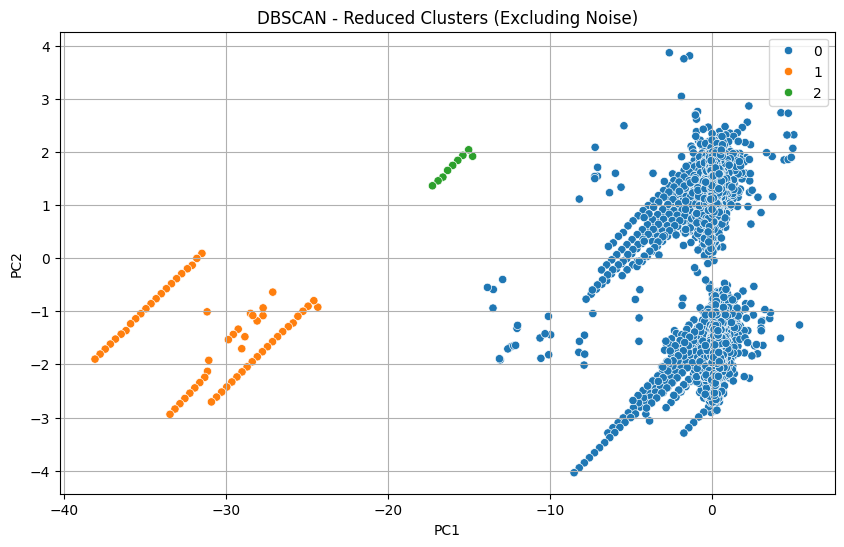

In [12]:

# Filter out noise (-1) and plot reduced clusters
df_core = df_pca[df_pca['Cluster'] != -1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_core, x='PC1', y='PC2', hue='Cluster', palette='tab10', legend='full')
plt.title("DBSCAN - Reduced Clusters (Excluding Noise)")
plt.legend()
plt.grid(True)
plt.show()


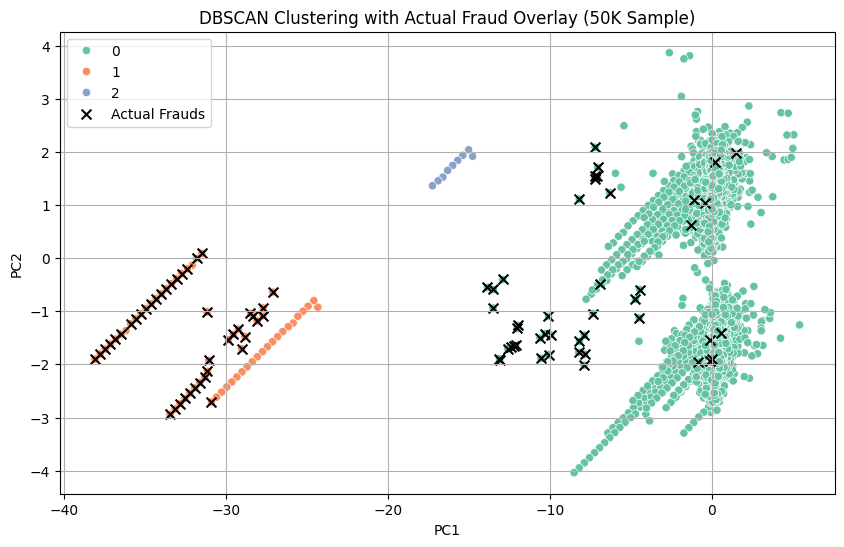

In [9]:
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', legend='full')
plt.scatter(df_pca[df_pca['Actual_Fraud'] == 1]['PC1'],
            df_pca[df_pca['Actual_Fraud'] == 1]['PC2'],
            color='black', marker='x', s=50, label='Actual Frauds')
plt.title("DBSCAN Clustering with Actual Fraud Overlay (50K Sample)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-13-2488644205.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


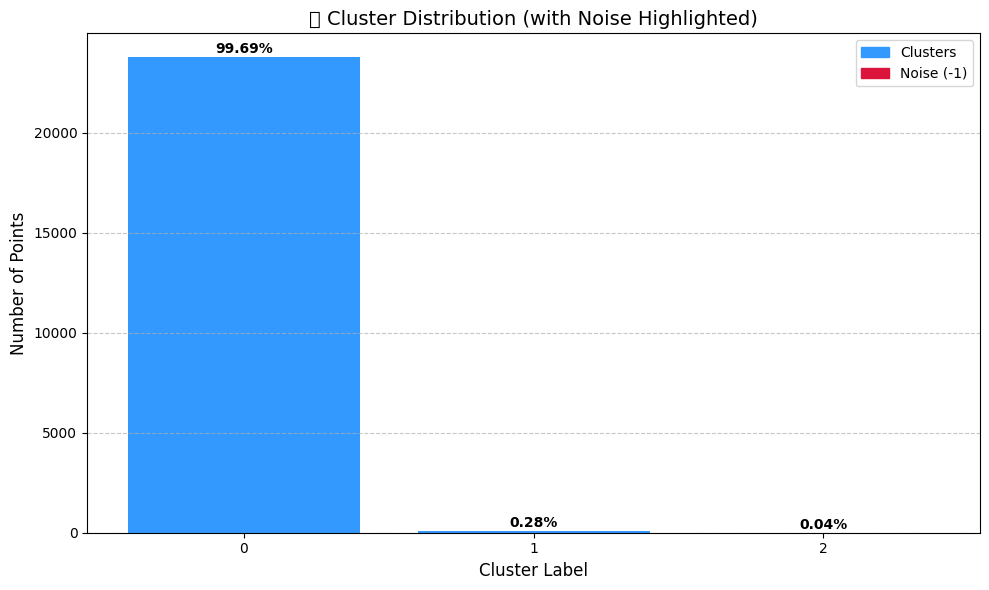

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert cluster labels to a Pandas Series (if not already)
cluster_series = pd.Series(cluster_labels, name='Cluster')

# Count points per cluster
cluster_counts = cluster_series.value_counts().sort_index()
total_points = cluster_counts.sum()

# Calculate percentage per cluster
percentages = (cluster_counts / total_points * 100).round(2)

# Set color: red for noise (-1), blue for others
colors = ['crimson' if i == -1 else '#3399FF' for i in cluster_counts.index]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color=colors)

# Annotate bars with percentage
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{pct}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
plt.title("📊 Cluster Distribution (with Noise Highlighted)", fontsize=14)
plt.xlabel("Cluster Label", fontsize=12)
plt.ylabel("Number of Points", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()

# Legend for noise
import matplotlib.patches as mpatches
noise_patch = mpatches.Patch(color='crimson', label='Noise (-1)')
cluster_patch = mpatches.Patch(color='#3399FF', label='Clusters')
plt.legend(handles=[cluster_patch, noise_patch])

plt.show()


/tmp/ipython-input-14-3512138232.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


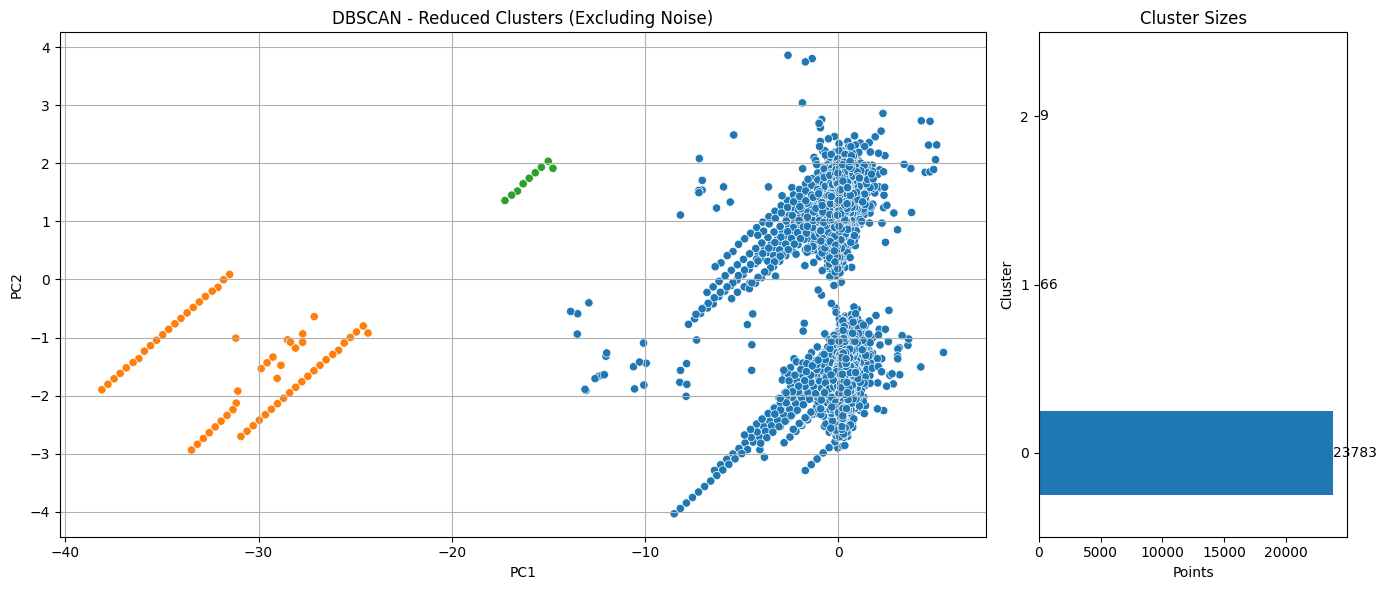

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# Filter out noise (-1)
df_core = df_pca[df_pca['Cluster'] != -1]

# Count points in each cluster
cluster_counts = df_core['Cluster'].value_counts().sort_index()

# Setup figure with gridspec (scatter on left, bar chart on right)
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
gs = GridSpec(1, 2, width_ratios=[3, 1], figure=fig)

# Scatter plot of clusters (left)
ax0 = fig.add_subplot(gs[0])
sns.scatterplot(data=df_core, x='PC1', y='PC2', hue='Cluster', palette='tab10', legend=False, ax=ax0)
ax0.set_title("DBSCAN - Reduced Clusters (Excluding Noise)")
ax0.grid(True)

# Side bar chart (right)
ax1 = fig.add_subplot(gs[1])
colors = sns.color_palette('tab10', n_colors=len(cluster_counts))
cluster_counts.plot(kind='barh', color=colors, ax=ax1)
ax1.set_title("Cluster Sizes")
ax1.set_xlabel("Points")
ax1.set_ylabel("Cluster")
for i, (val, count) in enumerate(zip(cluster_counts.index, cluster_counts.values)):
    ax1.text(count + 50, i, f"{count}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipython-input-15-1984179625.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


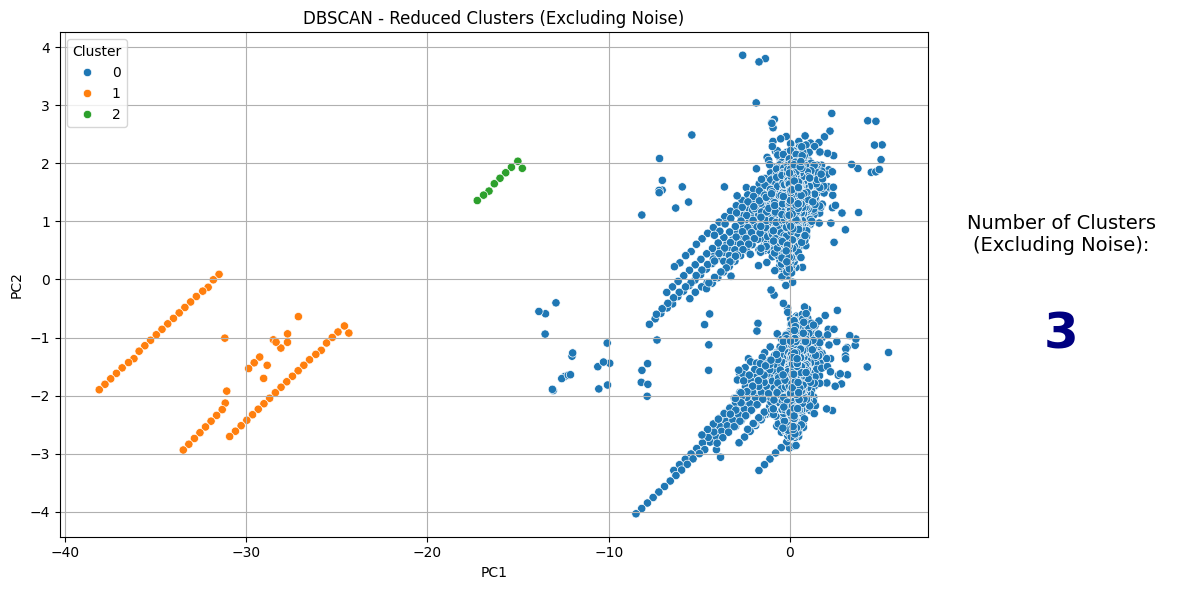

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Filter out noise (-1)
df_core = df_pca[df_pca['Cluster'] != -1]

# Count number of clusters (excluding noise)
n_clusters = df_core['Cluster'].nunique()

# Create the figure with 2 panels: left (scatter), right (text)
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[4, 1], figure=fig)

# Left: Scatter Plot of Reduced Clusters
ax0 = fig.add_subplot(gs[0])
sns.scatterplot(data=df_core, x='PC1', y='PC2', hue='Cluster', palette='tab10', legend='full', ax=ax0)
ax0.set_title("DBSCAN - Reduced Clusters (Excluding Noise)")
ax0.grid(True)

# Right: Display number of clusters
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')  # Hide axes
ax1.text(0.5, 0.6, "Number of Clusters\n(Excluding Noise):", fontsize=14, ha='center', va='center')
ax1.text(0.5, 0.4, f"{n_clusters}", fontsize=36, fontweight='bold', ha='center', va='center', color='navy')

plt.tight_layout()
plt.show()


/tmp/ipython-input-16-1990976908.py:41: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-1990976908.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


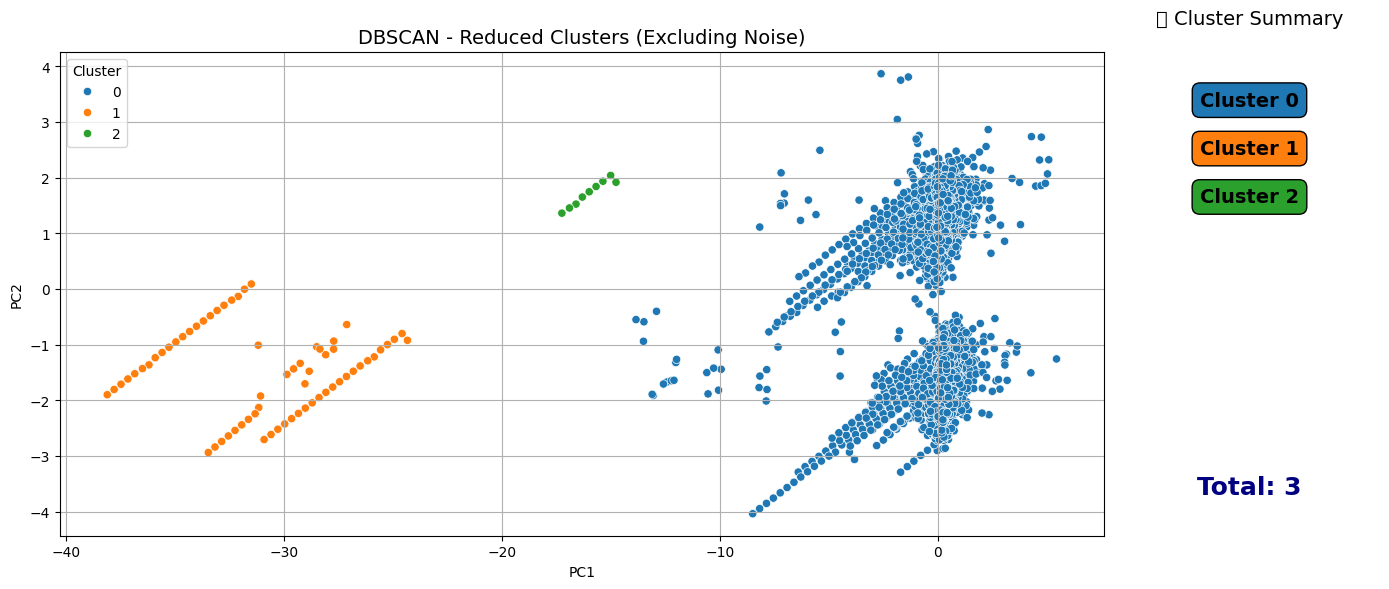

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Filter out noise (-1)
df_core = df_pca[df_pca['Cluster'] != -1]

# Unique clusters (excluding noise)
unique_clusters = sorted(df_core['Cluster'].unique())
n_clusters = len(unique_clusters)

# Create the figure with 2 panels: scatter and cluster count
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
gs = GridSpec(1, 2, width_ratios=[4, 1], figure=fig)

# --- Left: Scatter Plot ---
ax0 = fig.add_subplot(gs[0])
palette = sns.color_palette('tab10', n_colors=n_clusters)
sns.scatterplot(data=df_core, x='PC1', y='PC2', hue='Cluster', palette=palette, legend='full', ax=ax0)
ax0.set_title("DBSCAN - Reduced Clusters (Excluding Noise)", fontsize=14)
ax0.grid(True)

# --- Right: Colorful Cluster Count Representation ---
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')  # Turn off axis

# Display number of clusters as colorful blocks
ax1.set_title("🌈 Cluster Summary", fontsize=14, pad=20)

for i, cluster in enumerate(unique_clusters):
    ax1.text(0.5, 1 - (i+1)*(0.1), f"Cluster {cluster}",
             fontsize=14, fontweight='bold',
             ha='center', va='center',
             bbox=dict(facecolor=palette[i], boxstyle="round,pad=0.4", edgecolor='black'))

# Add total count at the bottom
ax1.text(0.5, 0.1, f"Total: {n_clusters}", fontsize=18, fontweight='bold',
         ha='center', va='center', color='navy')

plt.tight_layout()
plt.show()
